#### Installing Unsloth, Xformers and Loading Gemma7b model

In [1]:
%%capture
# Installing Unsloth and all other packages!
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps xformers trl peft accelerate bitsandbytes

In [2]:
from unsloth import FastLanguageModel
import torch

max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/gemma-7b-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
==((====))==  Unsloth: Fast Gemma patching release 2024.7
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.26.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


#### Configuring a Fast Language Model with PEFT using LoRA adapters

In [3]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    
    #"unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2024.7 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


#### Data Prep
We use the TREC-CAsT dataset from [treccastweb](https://github.com/daltonj/treccastweb/tree/master)

In [4]:
import json

# Load the JSON file
file_path = "2022_automatic_evaluation_topics_flattened_duplicated_v1.0.json"
with open(file_path, 'r') as file:
    data = json.load(file)

# Convert the data into the desired structure
converted_data = []
for conversation in data:
    for turn in conversation['turn']:
        converted_entry = {
            "instruction": turn.get("utterance", ""),
            "input": turn.get("automatic_rewritten_utterance", ""),
            "response": turn.get("response", "")
        }
        converted_data.append(converted_entry)

# Print or save the converted data
output_path = 'converted_data.json'
with open(output_path, 'w') as output_file:
    json.dump(converted_data, output_file, indent=4)

print("Data conversion complete. Output saved to", output_path)

Data conversion complete. Output saved to converted_data.json


In [5]:
from transformers import AutoTokenizer
from datasets import Dataset

prompt = """
### Instruction:
{}

### Input:
{}

### Response:
{}"""


# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("unsloth/gemma-7b-bnb-4bit")
EOS_TOKEN = tokenizer.eos_token

def formatting_prompts_func(examples):
    texts = []
    for i in range(len(examples["instruction"])):
        instruction = examples["instruction"][i]
        input = examples["input"][i]
        response = examples["response"][i]

        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = prompt.format(instruction, input, response) + EOS_TOKEN
        texts.append(text)

    return {"text": texts}

# Path to the JSON file
json_file_path = 'converted_data.json'

# Load the JSON data with utf-8-sig encoding
with open(json_file_path, 'r', encoding='utf-8-sig') as file:
    data = json.load(file)

# Create a Dataset object directly from the list of dictionaries
dataset = Dataset.from_list(data)

# Apply the formatting function
dataset = dataset.map(formatting_prompts_func, batched=True)

print(dataset[0])

Map:   0%|          | 0/284 [00:00<?, ? examples/s]

{'instruction': 'I remember Glasgow hosting COP26 last year, but unfortunately I was out of the loop. What was it about?', 'input': 'What was Glasgow hosting COP26 about?', 'response': 'The COP26 event is a global united Nations summit about climate change and how countries are planning to tackle it. The term “climate change” is often used as if it means the same thing as the term “global warming”. The National Academy of Sciences says “climate change” is growing in favor of “global warming” because it helps convey that there are other changes in addition to rising temperatures. In fact, “climate change” means major changes in temperature, rainfall, snow, or wind patterns lasting for decades or longer.', 'text': '\n### Instruction:\nI remember Glasgow hosting COP26 last year, but unfortunately I was out of the loop. What was it about?\n\n### Input:\nWhat was Glasgow hosting COP26 about?\n\n### Response:\nThe COP26 event is a global united Nations summit about climate change and how cou

#### Setting Up SFTTrainer for Fine-Tuning Gemma 7B

In [6]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

# Ensure padding_side is set to 'right' to avoid potential issues
tokenizer.padding_side = 'right'

trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=dataset,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    dataset_num_proc=2,
    packing=False,  # Can make training 5x faster for short sequences.
    args=TrainingArguments(
        per_device_train_batch_size=2,
        gradient_accumulation_steps=4,
        warmup_steps=5,
        max_steps=60,
        learning_rate=2e-4,
        fp16=not is_bfloat16_supported(),
        bf16=is_bfloat16_supported(),
        logging_steps=1,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear",
        seed=3407,
        output_dir="outputs",
    ),
)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:294: UserWarning: You passed a `dataset_num_proc` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:318: UserWarning: You passed a `dataset_text_field` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map (num_proc=2):   0%|          | 0/284 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


#### Current memory stats

In [7]:
gradient_checkpointing=True,  # Enable gradient checkpointing to save memory
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.748 GB.
5.83 GB of memory reserved.


#### Training Gemma 7B and Capturing Training Statistics with SFTTrainer

In [8]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 284 | Num Epochs = 2
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 60
 "-____-"     Number of trainable parameters = 50,003,968


Step,Training Loss
1,2.388100
2,2.611000
3,2.429900
4,2.372300
5,2.253100
6,2.296700
7,2.152600
8,1.985100
9,2.185400
10,2.111800


#### Final memory and time stats

In [9]:
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

396.7301 seconds used for training.
6.61 minutes used for training.
Peak reserved memory = 7.17 GB.
Peak reserved memory for training = 1.34 GB.
Peak reserved memory % of max memory = 48.617 %.
Peak reserved memory for training % of max memory = 9.086 %.


#### Inference
Let's run the model! I change the instruction and input, and leave the output as blank.

In [10]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    prompt.format(
        "Continue the fibonnaci sequence.", # instruction
        "0, 1, 1, 2, 3, 5", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 64)

<bos>
### Instruction:
Continue the fibonnaci sequence.

### Input:
0, 1, 1, 2, 3, 5

### Response:
8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584, 4181


 #### We can also use a TextStreamer for continuous inference - To see the generation token by token, instead of waiting the whole time!

In [11]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    prompt.format(
        "What is COP26?", # instruction
        "What is COP26?", #input
        "", # output
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 128, use_cache = True)
# tokenizer.batch_decode(outputs)

decoded_output = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]

# Split the decoded output by specific markers
sections = decoded_output.split('###')

# Print each section line by line
for section in sections:
    print(section.strip())


Instruction:
What is COP26?
Input:
What is COP26?
Response:
The United Nations Climate Change Conference (COP26) is a global summit about how the world plans to tackle climate change. It is the 26th annual meeting of the Conference of the Parties to the United Nations Framework Convention on Climate Change (UNFCCC). The COP26 summit will be held in Glasgow, Scotland, from November 1 to 12, 2021.


#### Saving finetuned model

In [12]:
model.save_pretrained("Gemma_Model") # Local saving
tokenizer.save_pretrained("Gemma_Model")

('Gemma_Model/tokenizer_config.json',
 'Gemma_Model/special_tokens_map.json',
 'Gemma_Model/tokenizer.model',
 'Gemma_Model/added_tokens.json',
 'Gemma_Model/tokenizer.json')

#### Loading the Fine-Tuned Model for Inference and Generating Outputs

In [13]:
if True: #saved for inference, set `False` to `True`
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "Gemma_Model", # Loading saved model
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )
    FastLanguageModel.for_inference(model) # Enable native 2x faster inference
    
inputs = tokenizer(
[
    prompt.format(
        "What is COP26?", # instruction
        "What is COP26?", #input
        "", # output
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)

# tokenizer.batch_decode(outputs)
decoded_output = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]

# Split the decoded output by specific markers
sections = decoded_output.split('###')

# Print each section line by line
for section in sections:
    print(section.strip())

==((====))==  Unsloth: Fast Gemma patching release 2024.7
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.26.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth

Instruction:
What is COP26?
Input:
What is COP26?
Response:
The United Nations Climate Change Conference (COP26) is a global summit about how the world plans to tackle climate change. It is the 26th annual meeting of the Conference of the Parties to the United Nations Framework Convention on Climate Change (UNFCCC). The COP26 summit will be held in Glasgow,


In [14]:
inputs = tokenizer(
[
    prompt.format(
        "How many states are there in Germany, please name them?", # instruction
        "Just tell names of the states", #input
        "", # output
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 128, use_cache = True)

# tokenizer.batch_decode(outputs)
decoded_output = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]

# Split the decoded output by specific markers
sections = decoded_output.split('###')

# Print each section line by line
for section in sections:
    print(section.strip())


Instruction:
How many states are there in Germany, please name them?
Input:
Just tell names of the states
Response:
There are 16 states in Germany. They are Baden-Württemberg, Bavaria, Berlin, Brandenburg, Bremen, Hamburg, Hesse, Mecklenburg-Vorpommern, Lower Saxony, North Rhine-Westphalia, Rhineland-Palatinate, Saarland, Saxony, Saxony-Anhalt, Schleswig-Holstein, and Thuringia.


#### BLEU and ROUGE Score Evaluation

In [15]:
pip install rouge_score

Note: you may need to restart the kernel to use updated packages.


In [27]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from rouge_score import rouge_scorer

nltk.download('punkt')

predictions = []
references = []

[nltk_data] Downloading package punkt to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [28]:
# Limit to 100 instances
for i, example in enumerate(dataset):
    if i >= 100:
        break
    print(f"\rProcessing example {i+1}/100", end='', flush=True)

    input_text = example['input']
    reference_text = example['response']

    # Generate predictions
    inputs = tokenizer(input_text, return_tensors="pt").to("cuda")
    outputs = model.generate(inputs.input_ids, max_length=512)
    predicted_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    predictions.append(predicted_text)
    references.append(reference_text)

# Print a newline after the loop completes
print("\nEvaluation Complete.")

# Tokenize predictions and references
predictions_tokenized = [nltk.word_tokenize(pred) for pred in predictions]
references_tokenized = [[nltk.word_tokenize(ref)] for ref in references]

Processing example 100/100
Evaluation Complete.


In [29]:
# Calculate BLEU Score
bleu_score = corpus_bleu(references_tokenized, predictions_tokenized)
print("BLEU Score:", bleu_score)

# Calculate ROUGE Score
rouge_scorer_instance = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL', 'rougeLsum'], use_stemmer=True)
rouge_scores = [rouge_scorer_instance.score(ref, pred) for ref, pred in zip(references, predictions)]

# Average ROUGE Scores
rouge1_avg = sum(score['rouge1'].fmeasure for score in rouge_scores) / len(rouge_scores)
rouge2_avg = sum(score['rouge2'].fmeasure for score in rouge_scores) / len(rouge_scores)
rougeL_avg = sum(score['rougeL'].fmeasure for score in rouge_scores) / len(rouge_scores)
rougeLsum_avg = sum(score['rougeLsum'].fmeasure for score in rouge_scores) / len(rouge_scores)
average_rouge = (rouge1_avg + rouge2_avg + rougeL_avg + rougeLsum_avg) / 4

print("ROUGE-1 Score:", rouge1_avg)
print("ROUGE-2 Score:", rouge2_avg)
print("ROUGE-L Score:", rougeL_avg)
print("ROUGE-Lsum Score:", rougeLsum_avg)
print("Average-ROUGE Score:", rougeLsum_avg)

BLEU Score: 0.012958126411085355
ROUGE-1 Score: 0.1470084765809958
ROUGE-2 Score: 0.03921729189479525
ROUGE-L Score: 0.10485267543053492
ROUGE-Lsum Score: 0.08949320186753988
Average-ROUGE Score: 0.08949320186753988


#### Visualization

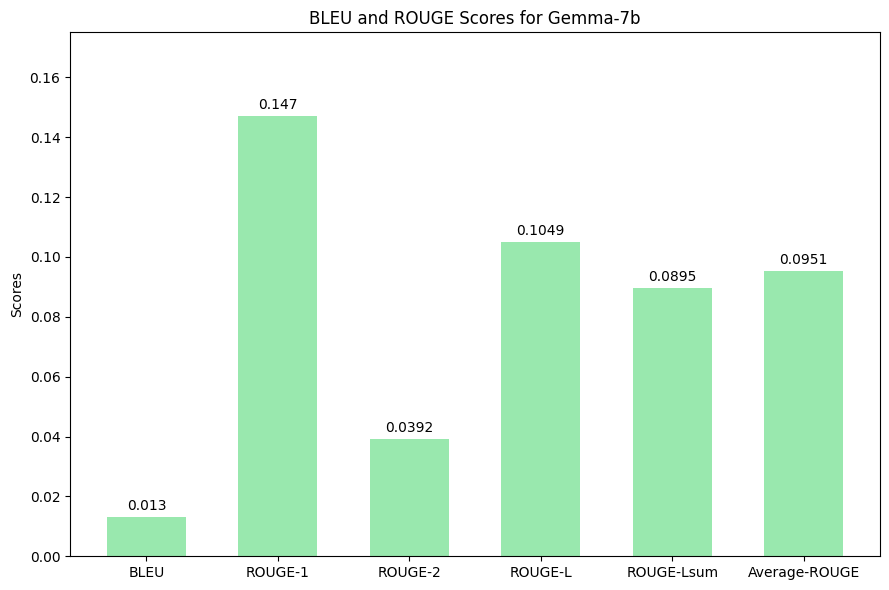

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Plotting the scores
labels = ['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'ROUGE-Lsum', 'Average-ROUGE']
scores = [bleu_score, rouge1_avg, rouge2_avg, rougeL_avg, rougeLsum_avg, average_rouge]

color = '#99e8ae'

x = np.arange(len(labels))  # the label locations
width = 0.6  # the width of the bars

fig, ax = plt.subplots(figsize=(9, 6))
rects = ax.bar(x, scores, width, color=color)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('BLEU and ROUGE Scores for Gemma-7b')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 0.175)  # BLEU and ROUGE scores range from 0 to 1

# Attach a text label above each bar in *rects*, displaying its height.
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 4)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects)

fig.tight_layout()

plt.show()